# Capstone Final Project-Battle of the Neighborhoods-wk1

By Lian Wang

July 2020

## Table of contents

* [Introduction](#Introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Results](#Results)
* [Discussions](#Discussions)
* [Conclusions](#Conclusions)



## Introduction

In this age of convenient and efficient tranportation means, travelling around the world becomes easier and more common. In fact, people relocate around the world more often too with the globalization trend. 

When people move from one city to another, most simply pick an area/neighborhood near work/school first, then move to a different area/neighbor if desired after settling down and getting to know the surrounding areas more. Moving, sometimes several times, isn't unusual in this scenario. It is obviously not an optimal process since we are limited by the scope of information we have access to, often via word of mouth or physically checking out a few nearby areas. Moving, also brings anxiety for the common fear of unknown. It would be helpful if we are able to compare the new city to the city we currently live in to identify areas that might be a good living location for us in the new city, and be better prepared by understanding the difference in advance. It would potentially minimize the need or frequency of relocations, which is a big hassle for those relocating with a family, and ease the mental burden of relocation.

However, efforts to research a new city often only offer the city-level information, for example, population, histories, economic condition, climates, etc. It gives the overall picture of the city, which is more suitable for tourists but not for selecting an area for living. For the latter purpose, it is the neighborhood-level details, such as what kind of shops, entertaining facilities, athletic centers and schools nearby, that are the focus of considerations.

Fortunately, with the advancement in technology, there are many location data platforms like **Foursquare** that provide detailed information on all kinds of venues around any geographical locations of interest. In this project, we intend to marry the rich location data provided by **Foursquare** and the power of machine learning to undertake comparisons of neighborhoods in two (or more) cities to fill this void of comparative information at the neighborhood level. We hope to help making relocation an easier and better experience with this additional dimension of information (packaged in a tool, if turn into a future App). Neighborhood-level comparisons among cities could also be valuable for people exploring and searching for their next stop (city) in life. For this project, we will focus on comparing the neighborhoods in New York City and Toronto as an illustrative example. The objective will be to provide a summary of how different/similar the two cities are based on their neighborhoods, as well as to offer recommendations for relocating between the two cities. 



### Data

In order to use the **Foursquare** platform to gather neighborhood venue information, we need data that contains the neighborhoods exist in each city as well as the latitude and logitude coordinates of each neighborhood. 





We will first install packages and load the necessary libraries. The codes in the cell below was run twice. First time included the installation of packages geopy and folium, which took a long time and genearted a lot of distracting outputs. The second time were run with the two installation lines commented out to hide the outputs from installation.

In [46]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # comment out this line once installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values, commented out after first run

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#from pandas import json_normalize # for a newer Python version?

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # comment out this line once installed
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 1. Load and extract neighborhood data for New York City

For New York city, this data had been compiled and exists in one file at https://cocl.us/new_york_dataset for this IBM course. The original source of this data is from https://geo.nyu.edu/catalog/nyu_2451_34572.

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    ny_data = json.load(json_data)
    
nyNBHs_data = ny_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nyNBHs = pd.DataFrame(columns=column_names)

for data in nyNBHs_data:
    borough = data['properties']['borough'] # 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyNBHs = nyNBHs.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
nyNBHs['City'] = 'New York City'

nyNBHs.head() # if from saved combined NBHs dataframe, could use the subset nyNBHs = NBHs[NBHs['City']=='New York City']

Data downloaded!


,Borough,Neighborhood,Latitude,Longitude,City
0,Bronx,Wakefield,40.894705,-73.847201,New York City
1,Bronx,Co-op City,40.874294,-73.829939,New York City
2,Bronx,Eastchester,40.887556,-73.827806,New York City
3,Bronx,Fieldston,40.895437,-73.905643,New York City
4,Bronx,Riverdale,40.890834,-73.912585,New York City


nyNBHs is the data frame containing the New York City neighborhood data needed, and the output above shows the first 5 rows of the data. We could see there are 306 neighborhoods in New York City.

In [3]:
print('There are {} neighborhoods in New York City'.format(nyNBHs.shape[0]))

There are 306 neighborhoods in New York City


We could use Nominatim function in geopy library to extract the latitude and longitude of New York City and visualize the city with its neighborhoods in a map.

In [3]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="city_explorer")
location = geolocator.geocode(address)
latitudeNY = location.latitude
longitudeNY = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitudeNY, longitudeNY)) ## 40.7127281, -74.0060152, if to avoid installing geopy

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [4]:
# bypass using geolocator.geocode() after the first time, because install geopy takes too long
latitudeNY = 40.7127281
longitudeNY = -74.0060152

In [5]:
# create map of New York using latitude and longitude values
map_NY= folium.Map(location=[latitudeNY, longitudeNY], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(nyNBHs['Latitude'], nyNBHs['Longitude'], nyNBHs['Borough'], nyNBHs['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc', 
        fill_opacity=0.7,
        parse_html=False).add_to(map_NY)  
    
map_NY

### NOTE, Github can't render folium map. Please go to https://nbviewer.jupyter.org/, and use the link provided by me to view the notebook with map rendering capacity.

### 2. Load and create neighborhood data for Toronto

For Toronto, the list of neighborhood and corresponding postal code will be scraped from this Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. Even though we could use geocoder Python package to retrieve the geographical location data based on postal codes, this package is unreliable (could get stuck in the process for unreasonably long time if using a while loop to ensure getting a result for each postal code). So, we will use the csv file containing the geographical location data for each of the postal code in Toronto that is provided for this IBM course at http://cocl.us/Geospatial_data.

In [6]:
dfs = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M') 
#dfs[0].head()  #dfs[0] is the table we need

# assign dfs[0] to a new dataframe
df_tor = dfs[0]

# drop rows with Borough=='Not assigned'
df_tor = df_tor[df_tor.Borough != 'Not assigned'].reset_index(drop=True)
print('The shape of the data',df_tor.shape)
df_tor.head()

#(df_tor.Neighborhood=='Not assigned').value_counts() # 103 False, no "Not assigned" Neighborhood after dropping "Not assigned" Boroughs

print('There are {} rows of data.'.format(df_tor.shape[0]))


The shape of the data (103, 3)
There are 103 rows of data.


In [7]:
torCoordFromFile = pd.read_csv('http://cocl.us/Geospatial_data') # postal code with corresponding geographical data
#torCoordFromFile.head()

torNBHs=pd.merge(df_tor,torCoordFromFile)
torNBHs['City'] = 'Toronto'
torNBHs.rename(columns={'Neighbourhood':"Neighborhood"},inplace=True)

torNBHs.head() 


,Postal Code,Borough,Neighborhood,Latitude,Longitude,City
0,M3A,North York,Parkwoods,43.753259,-79.329656,Toronto
1,M4A,North York,Victoria Village,43.725882,-79.315572,Toronto
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Toronto
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto


torNBHs is the data frame containing the Toronto neighborhood data needed, and the output above shows the first 5 rows of the data. We could see there are 103 neighborhoods/postal codes in Toronto.

Visualizing Toronto with its neighborhoods in a map.

In [11]:
address = 'Toronto, Ontario'

location = geolocator.geocode(address)
latitudeTor = location.latitude
longitudeTor = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitudeTor, longitudeTor)) # 43.6534817, -79.3839347, if to avoid installing geopy

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [8]:
# bypass using geolocator.geocode() after the first time, because install geopy takes too long
latitudeTor = 43.6534817
longitudeTor = -79.3839347

In [9]:
# create map of Toronto using latitude and longitude values
map_Tor= folium.Map(location=[latitudeTor, longitudeTor], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(torNBHs['Latitude'], torNBHs['Longitude'], torNBHs['Borough'], torNBHs['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Tor)  
    
map_Tor

### NOTE, Github can't render folium map. Please go to https://nbviewer.jupyter.org/, and use the link provided by me to view the notebook with map rendering capacity.

### 3. Using Foursquare API to retrieve the venues data for neighborhoods

Once we have the neighborhood data with the appropriate geographical data for both cities, we will then use the **Foursquare API** to retrieve the venues infromation within a certain range of the rarius (say, 500 or 1000 meters) for each neighborhood. Service and activitiy venues, nearby within a neighborhood, are characteristics of a neighborhood and reflect the convenience and life style of people living in the area. Hence, quantifying these venues into categories and the associagted venue counts are meaningful features to use for classifying neighborhoods into clusters/groups. Because our purpose is to compare the two cities, we will compile a combined data set for clustering analysis based on neighborhood venue features, and then examine the distribution of the clusters/groups between the two cities.


In [10]:
NBHs = pd.concat([nyNBHs, torNBHs], ignore_index=True, join='inner') #combine the neighborhood data from the two cities into one
NBHs['City'].value_counts()

New York City    306
Toronto          103
Name: City, dtype: int64

The combined data frame contains 306 and 103 neighborhoods for New York City and Tornoto, respectively, matching the counts in separate data sets.

The hidden cell below contains the credential for accessing **Foursquare API**.

In [11]:
# The code was removed by Watson Studio for sharing.

Next, we borrow the _getNearbyVenues_ function from the course lab to request data from the API and extract relevant info.

In [12]:
def getNearbyVenues(cities, names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for city, name, lat, lng in zip(cities, names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



Retrieve up to 100 venues within 500 meters of the geographical location that defines each neighborhood, for all the neighborhoods in the two cities. We can see there are 12,223 venues returned, from 458 unique categories.

In [13]:
LIMIT = 100 # return top 100 venues 
radius = 500 # wihtin 500 meter of a location

# get the venues data for all the neighborhoods in combined NBHs data
Venues = getNearbyVenues(cities=NBHs['City'],
                         names=NBHs['Neighborhood'],
                         latitudes=NBHs['Latitude'],
                         longitudes=NBHs['Longitude']
                                  )
# checking the cleaned up data extracted from Foursquare
print(Venues.shape)
Venues.head()


(12223, 8)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York City,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,New York City,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,New York City,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,New York City,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,New York City,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station


In [14]:
# learn a bit more about the Venues data

print('There are {} unique categories.'.format(len(Venues['Venue Category'].unique())))
#Venues.groupby('Neighborhood').count()


There are 458 unique categories.


In [15]:
Venues.groupby(['City','Neighborhood']).count().describe() 

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,30.711055,30.711055,30.711055,30.711055,30.711055,30.711055
std,30.371826,30.371826,30.371826,30.371826,30.371826,30.371826
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
75%,41.750000,41.750000,41.750000,41.750000,41.750000,41.750000
max,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000


In [16]:
Venues.groupby(['City','Neighborhood']).count().sort_values(by=['Venue Category']).tail()

Neighborhood Latitude  \
City          Neighborhood                                            
New York City Downtown                                          100   
              East Village                                      100   
Toronto       Commerce Court, Victoria Hotel                    100   
New York City Chelsea                                           107   
              Murray Hill                                       147   

                                              Neighborhood Longitude  Venue  \
City          Neighborhood                                                    
New York City Downtown                                           100    100   
              East Village                                       100    100   
Toronto       Commerce Court, Victoria Hotel                     100    100   
New York City Chelsea                                            107    107   
              Murray Hill                                        147    147   

                                              Venue Latitude  Venue Longitude  \
City          Neighborhood                                                      
New York City Downtown                                   100              100   
              East Village                               100              100   
Toronto       Commerce Court, Victoria Hotel             100              100   
New York City Chelsea                                    107              107   
              Murray Hill                                147              147   

                                              Venue Category  
City          Neighborhood                                    
New York City Downtown                                   100  
              East Village                               100  
Toronto       Commerce Court, Victoria Hotel             100  
New York City Chelsea                                    107  
              Murray Hill                                147

When checking the range of venue numbers returned for individual neighborhood, we see that some neighborhoods only have one venue within the radius of 500 meters, while some have the max number of possible return of 100. We should keep in mind that there are potentially more than 100 venues for those neighborhoods. However, we also notice a couple neighborhoods ("Chelsea" and "Murray Hill") have over 100 venues, indicating there might be more than one Neighborhood named "Murray Hill"/"Chelsea". So, we went back to check how many Neighborhoods presented more than once in the neighborhood data.

The results from the next two code cells confirms what we observed that 6 Neighborhood names represented more than once in the NBHs data frame. After taking into consideration of different Borough, only two still showed up more than once.

In [17]:
NBHs.groupby(['City','Neighborhood']).count().sort_values(by=['Borough']).tail(10) # 

Borough  Latitude  Longitude
City          Neighborhood                                 
New York City Kew Gardens            1         1          1
              High  Bridge           1         1          1
              Jamaica Estates        1         1          1
              Jamaica Hills          1         1          1
              Chelsea                2         2          2
Toronto       Don Mills              2         2          2
New York City Sunnyside              2         2          2
              Murray Hill            2         2          2
              Bay Terrace            2         2          2
Toronto       Downsview              4         4          4

In [18]:
NBHs.groupby(['City','Borough','Neighborhood']).count().sort_values(by=['Latitude']).tail(10) # 

Latitude  Longitude
City          Borough    Neighborhood                           
New York City Manhattan  Gramercy                   1          1
                         Flatiron                   1          1
                         Financial District         1          1
                         East Village               1          1
                         East Harlem                1          1
                         Clinton                    1          1
                         Lenox Hill                 1          1
Toronto       York       Weston                     1          1
              North York Don Mills                  2          2
                         Downsview                  4          4

That was because these two neighborhoods were broken down by 2 and 4 different postal codes (with distinct latitude and longitude pairs), respectively.

In [21]:
torNBHs[torNBHs.Neighborhood.isin(['Don Mills','Downsview'])]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,City
7,M3B,North York,Don Mills,43.745906,-79.352188,Toronto
13,M3C,North York,Don Mills,43.725900,-79.340923,Toronto
40,M3K,North York,Downsview,43.737473,-79.464763,Toronto
46,M3L,North York,Downsview,43.739015,-79.506944,Toronto
53,M3M,North York,Downsview,43.728496,-79.495697,Toronto
60,M3N,North York,Downsview,43.761631,-79.520999,Toronto


Because our **Foursquare API** requests are based on each pair of (latitude, longitude) in the NBHs data frame, for later analysis, we will include the latitude and longitude information as grouping factors for rolling up data to neighborhood level, being aware that Don Mills and Downsview are represented by 2 and 4, respectively, sub-locations in our data.

### Methodology

Having data (in data frame "Venues") containing venues retrieved from **Foursquare API**, one natural question to ask is how many venues each neighborhood has. The total number of venues could be used as an indicator for how busy a neighborhood is. So our first step is to roll up the Venues data, which is per-venue per-row, into neighborhood-level (defined by each latitude/longitude pair). 

In [18]:
# adding venue counts and roll up to neighborhood-level
tmp = Venues[['City','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Category']]
tmp = tmp.groupby(['City','Neighborhood','Neighborhood Latitude','Neighborhood Longitude']).count().reset_index()
tmp.rename(columns={'Neighborhood Latitude':'Latitude','Neighborhood Longitude':'Longitude','Venue Category':'VenueCnt'},inplace=True)
NBH_grouped = tmp
NBH_grouped.head()

,City,Neighborhood,Latitude,Longitude,VenueCnt
0,New York City,Allerton,40.865788,-73.859319,31
1,New York City,Annadale,40.538114,-74.178549,13
2,New York City,Arden Heights,40.549286,-74.185887,6
3,New York City,Arlington,40.635325,-74.165104,5
4,New York City,Arrochar,40.596313,-74.067124,21


In addition, we could also count the unique venue categories in each neighborhood. This measure reflects the diversity of services/activities provided in the area and could be used as a surrogate for convenience of life in the neighborhood.

In [19]:
# adding unique venue category counts to the rolled up data
tmp = Venues[['City','Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue Category']]
tmp = tmp.groupby(['City','Neighborhood','Neighborhood Latitude','Neighborhood Longitude'])['Venue Category'].nunique().reset_index()
tmp.rename(columns={'Neighborhood Latitude':'Latitude','Neighborhood Longitude':'Longitude','Venue Category':'UniqueCateCnt'},inplace=True)

NBH_grouped = pd.merge(tmp,NBH_grouped)

Let's take a quick look at this rolled up data by showing the top 5 row and check the size of the data.

In [20]:
NBH_grouped.head()

,City,Neighborhood,Latitude,Longitude,UniqueCateCnt,VenueCnt
0,New York City,Allerton,40.865788,-73.859319,24,31
1,New York City,Annadale,40.538114,-74.178549,12,13
2,New York City,Arden Heights,40.549286,-74.185887,6,6
3,New York City,Arlington,40.635325,-74.165104,5,5
4,New York City,Arrochar,40.596313,-74.067124,17,21


In [22]:
NBH_grouped.shape

(404, 6)

### Remember we have 103+306=409 rows in our combined nighborhood data (NBHs), while we only have 404 rows in this rolled up data at neighborhood-level. This means there are 5 neighborhoods in our data without any return from the **Foursquare API** requests. We need to add these 5 neighborhoods back and assign zero to their venue count and unique venue category count. 

In [21]:
#use a outer join merge to keep all rows in the NBHs data 
colNames = NBHs.columns[1:5] #leave out the "Borough" column
NBH_grouped = pd.merge(NBH_grouped,NBHs[colNames],how='right')

#fill nan/na with zero
NBH_grouped = NBH_grouped.fillna(0)

NBH_grouped.describe() # to check that UniqueCateCnt and VenueCnt both have 409 counts and with minimum of zero

,Latitude,Longitude,UniqueCateCnt,VenueCnt
count,409.000000,409.000000,409.000000,409.000000
mean,41.457681,-75.318974,20.904645,29.885086
std,1.308187,2.371763,17.671934,29.862988
min,40.505334,-79.615819,0.000000,0.000000
25%,40.641718,-79.160497,7.000000,8.000000
50%,40.744049,-73.980890,16.000000,19.000000
75%,43.602414,-73.888452,28.000000,40.000000
max,43.836125,-73.708847,70.000000,100.000000


Visualize these two neighborhood-level metrics using histogram for two cities.

Text(0, 0.5, 'Frequency')

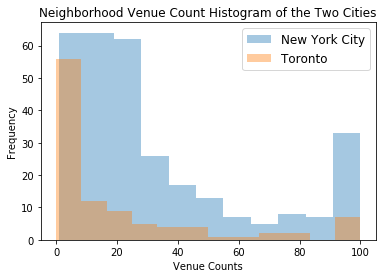

In [22]:
df = NBH_grouped[NBH_grouped.City == 'New York City']
sns.distplot(df['VenueCnt'],  kde=False, label='New York City')

df =NBH_grouped[NBH_grouped.City == 'Toronto']
sns.distplot(df['VenueCnt'],  kde=False,label='Toronto')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Neighborhood Venue Count Histogram of the Two Cities')
plt.xlabel('Venue Counts')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

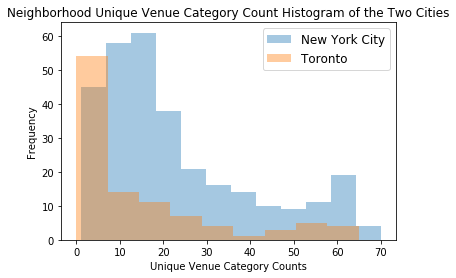

In [24]:
df = NBH_grouped[NBH_grouped.City == 'New York City']
sns.distplot(df['UniqueCateCnt'], kde=False,  label='New York City') #

df =NBH_grouped[NBH_grouped.City == 'Toronto']
sns.distplot(df['UniqueCateCnt'], kde=False, label='Toronto') #

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Neighborhood Unique Venue Category Count Histogram of the Two Cities')
plt.xlabel('Unique Venue Category Counts')
plt.ylabel('Frequency')

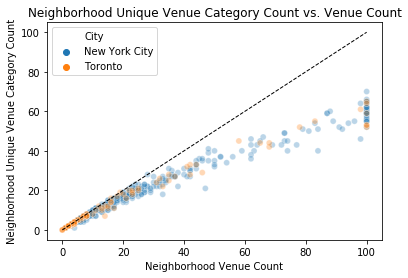

In [23]:
sns.scatterplot(x='VenueCnt', y='UniqueCateCnt', data=NBH_grouped,  hue='City',alpha=0.3) #marker= 'D', 


plt.title('Neighborhood Unique Venue Category Count vs. Venue Count')
plt.xlabel('Neighborhood Venue Count')
plt.ylabel('Neighborhood Unique Venue Category Count')

# add diagonal line
#ax.axline((1, 1), slope=1) # not working
mn = min(NBH_grouped.VenueCnt.min(), NBH_grouped.UniqueCateCnt.min())
mx = max(NBH_grouped.VenueCnt.max(), NBH_grouped.UniqueCateCnt.max())
points = np.linspace(mn, mx, 100)
plt.gca().plot(points, points, color='k', marker=None, linestyle='--', linewidth=1.0)


From these 3 graphs, we could see that New York City has more neighborhoods that are very busy and that have very diverse services than Toronto. However, Toronto isn't too much different from New York City in that its neighborhoods do cover the same span with regard to these two indicators. In another word, for people relocating betweend the two cities, they most likely will be able to find some target neighborhoods of interest in the new city based on their knowledge of the current city they live in. 

Next, we will use the one hot encoding to reshape the Venues data into the wide-form. 

In [25]:
# one hot encoding
Venues_onehot = pd.get_dummies(Venues[['Venue Category']], prefix="", prefix_sep="")
Venues_onehot.rename(columns={'Neighborhood':'NeighborhoodCate'},inplace=True)

# add city, neighborhood as well as the neighborhood latitude/longitude columns back to dataframe
tmp = Venues.iloc[:,0:4]
tmp.rename(columns={'Neighborhood Latitude':'Latitude', 'Neighborhood Longitude':'Longitude'},inplace=True)
Venues_onehot = pd.concat([tmp,Venues_onehot], axis=1) 

# move neighborhood column to the first column
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
#toronto_onehot = toronto_onehot[fixed_columns]

Venues_onehot.head()



,City,Neighborhood,Latitude,Longitude,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellan

Now sum up the venue counts in each venue category to the neighborhood level. The retrieved venue counts in each venue category within a neighborhood will be used as teh features for clustering neighborhoods.

In [26]:
print('The shape of Venues_onehot is',Venues_onehot.shape)

Venues_grouped = Venues_onehot.groupby(['City','Neighborhood','Latitude','Longitude']).sum().reset_index()

#add back the zero venue neighborhoods
colNames = NBHs.columns[1:5] #leave out the "Borough" column
Venues_grouped = pd.merge(Venues_grouped,NBHs[colNames],how='right')
Venues_grouped = Venues_grouped.fillna(0)
print('The shape of Venues_grouped is',Venues_grouped.shape)

The shape of Venues_onehot is (12223, 462)
The shape of Venues_grouped is (409, 462)


In [27]:
# prepare the 
X=Venues_grouped.drop(['City','Neighborhood','Latitude','Longitude'],axis=1) # data with all venue categories for Kmeans modeling


# other features tried
#X=Venues_grouped[selectCate] # data with top 100 venues for Kmeans modeling
#X=NBH_grouped.drop(['City','Neighborhood','Latitude','Longitude'],axis=1) # data with only venue count and unique venue category count for Kmeans modeling
#X=Venues_grouped_focus[['Commute','kidActive','parentActive','Shopping','UniqueCateCnt','VenueCnt']]


#from sklearn.preprocessing import MinMaxScaler # not to scale, because each feature is number of counts, they are in essence of the same scale
#X = MinMaxScaler().fit_transform(X)

Use the Elbow-method to check for the suggested culster number by the data. There isn't a clear "elbow" though. Seems like 3-6 clusters should be used. 

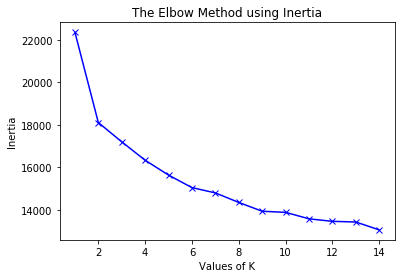

In [28]:
#elbow-method to find the optimal cluster number
inertias = [] 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)    
    inertias.append(kmeanModel.inertia_) 
   
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Using the Silhouette-method, it suggests that 3 clusters should be used. 

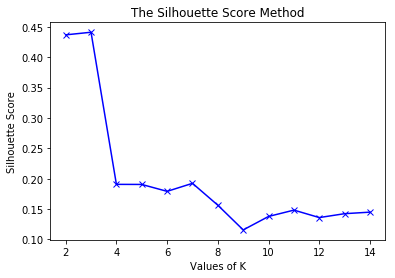

In [29]:
from sklearn.metrics import silhouette_score #, davies_bouldin_score

score = []
K = range(2,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X)
    #preds = kmeanModel.fit_predict(X)
    clusters = kmeanModel.labels_

    score.append(silhouette_score(X, clusters,metric = 'euclidean')) 

plt.plot(K, score, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette Score') 
plt.title('The Silhouette Score Method') 
plt.show() 

With Davies-Bouldin score, it suggests that 4 clusters should be used. 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: Runtim

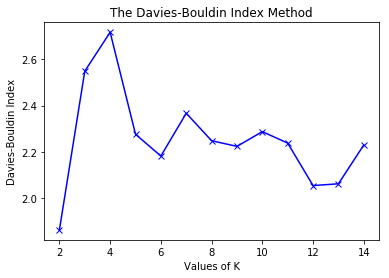

In [30]:
from sklearn.metrics import davies_bouldin_score

score = []
K = range(2,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X)
    #preds = kmeanModel.fit_predict(X)
    clusters = kmeanModel.labels_

    score.append(davies_bouldin_score(X, clusters)) 

plt.plot(K, score, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Davies-Bouldin Index') 
plt.title('The Davies-Bouldin Index Method') 
plt.show() 

With some testing and practical consideration, we decide to use 4 clusters. When using 3 clusters, it results in a very large cluster (including over 300 neighborhoods) and 2 relatively small clusters. When using 5 or 6 clusters, there is a cluster of only 2 neighborhoods. With 4 clusters, we have better sized clusters that are not super large (>300) nor super small (<5).

Cluster the neighborhoods into 4 clusters and extract the clustering result to merge with the NBH_grouped data. We see the 4 clusters have 238, 104, 46, and 21 neighborhoods in them respectively.

In [48]:
# set number of clusters
kclusters = 4# 

kmeanModel = KMeans(n_clusters=kclusters).fit(X)

In [32]:
tmp = Venues_grouped[['City','Neighborhood','Latitude','Longitude']] 
tmp.insert(4, 'Cluster Labels', kmeanModel.labels_)

tmp = pd.merge(NBH_grouped,tmp)

#tmp = Venues_grouped_focus.copy

#tmp.insert(4, 'Cluster Labels', kmeanModel.labels_)

tmp['Cluster Labels'].value_counts()


2    238
1    104
0     46
3     21
Name: Cluster Labels, dtype: int64

Examine the venue count distribution in the clusters. We observe:
* Cluster 0: Most with high venue counts (>60) 
* Culster 1: Most with medium venue counts (20-60)
* Cluster 2: Most with low venue counts (<20)
* Cluster 3: Most with high venue counts (>60)

Text(0, 0.5, 'Frequency')

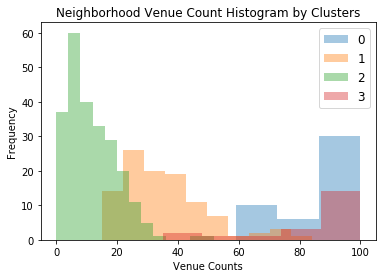

In [33]:
for k in range(0,kclusters): #[1,3]: #
    df = tmp[tmp['Cluster Labels']==k]
    sns.distplot(df['VenueCnt'],kde=False,label=str(k))

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Neighborhood Venue Count Histogram by Clusters')
plt.xlabel('Venue Counts')
plt.ylabel('Frequency')

Examine the unique venue category count distribution in the clusters. We have similar observations as for the venue count:
* Cluster 0: Most with high unique venue category counts (>40) 
* Culster 1: Most with medium unique venue category counts (20-40)
* Cluster 2: Most with low unique venue category counts (<20)
* Cluster 3: Most with high unique venue category counts (>40)

Text(0, 0.5, 'Frequency')

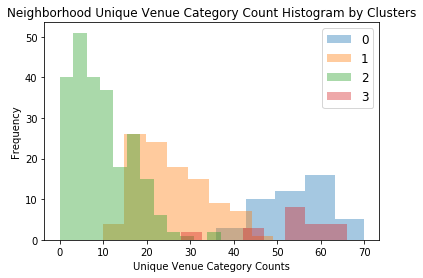

In [34]:
for k in range(0,kclusters): #[1,3]: #
    df = tmp[tmp['Cluster Labels']==k]
    sns.distplot(df['UniqueCateCnt'],kde=False,label=str(k))

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Neighborhood Unique Venue Category Count Histogram by Clusters')
plt.xlabel('Unique Venue Category Counts')
plt.ylabel('Frequency')

Use crosstab() function to examine the number of neighborhoods in each cluster in each City. 

In [36]:
compare = pd.crosstab(tmp['Cluster Labels'],tmp.City)
compare


City,New York City,Toronto
Cluster Labels,,
0,45,1
1,93,11
2,160,78
3,8,13


A chi-square test on the contingency table indicates the neighborhood distributions among the clusters are different between the two cities (p<0.0001). 

In [37]:
from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(compare)
print('p-value is', p)

p-value is 3.4617680064700026e-10


We use a side-by-side bar plot to visualize the proportion of neighborhoods in each cluster for both cities.

In [38]:
#compare.reset_index(inplace=True)
compare['New York City']= compare['New York City']/306*100
compare['Toronto'] = compare['Toronto']/103*100


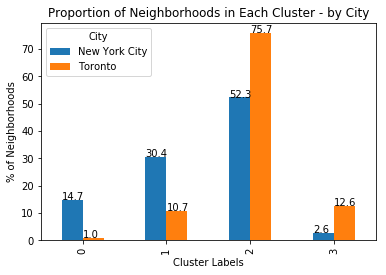

In [39]:
ax = compare.plot(kind='bar')
ax.set_title('Proportion of Neighborhoods in Each Cluster - by City')
ax.set_ylabel('% of Neighborhoods')
for p in ax.patches:
    ax.annotate("{:.1f}".format(p.get_height()),
                xy=(p.get_x()+0.0, p.get_height()+0.02)) # ,fontsize=13


Visualize the two cities with neighborhoods superimposed as markers color-coded according to their cluster designation.

In [42]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# set color scheme for the clusters

colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

current_palette = sns.color_palette()
Color= [colors.rgb2hex(i) for i in current_palette]


In [43]:
ny_tmp =tmp[tmp['City']=='New York City']
ny_tmp = pd.merge(nyNBHs,ny_tmp)
# create map of New York using latitude and longitude values
map_NY_Cluster= folium.Map(location=[latitudeNY, longitudeNY], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, cluster in zip(ny_tmp['Latitude'], ny_tmp['Longitude'], ny_tmp['Borough'], ny_tmp['Neighborhood'],ny_tmp['Cluster Labels']):
    label = 'Neighborhood: {}, Borough: {}, Cluster: {}'.format(neighborhood, borough, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=Color[cluster],
        fill=True,
        fill_color=Color[cluster], 
        fill_opacity=0.7,
        parse_html=False).add_to(map_NY_Cluster)  
    
map_NY_Cluster

Above is the map for New York City. High venue counts/uniuqe venue category counts neighborhoods aggregated around Manhattan. Low to medium venue counts/unique venue category counts neighborhoods spread outside and farther away from Manhattan. The cluster designation could be found in the pop-up for each neighborhood. Or, the color legend is the same as those for the 

### NOTE, Github can't render folium map. Please go to https://nbviewer.jupyter.org/, and use the link provided by me to view the notebook with map rendering capacity.

In [44]:
tor_tmp =tmp[tmp['City']=='Toronto']
tor_tmp = pd.merge(torNBHs,tor_tmp)
# create map of Toronto using latitude and longitude values
map_Tor_Cluster= folium.Map(location=[latitudeTor, longitudeTor], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood, cluster in zip(tor_tmp['Latitude'], tor_tmp['Longitude'], tor_tmp['Borough'], tor_tmp['Neighborhood'],tor_tmp['Cluster Labels']):
    label = 'Neighborhood: {}, Borough: {}, Cluster: {}'.format(neighborhood, borough, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=Color[cluster],
        fill=True,
        fill_color=Color[cluster], 
        fill_opacity=0.7,
        parse_html=False).add_to(map_Tor_Cluster)  
    
map_Tor_Cluster

Above is the map for Toronto. We see similar pattern in the distribution of the neighborhood clusters, with high venue counts/high unique venue category counts neighborhoods concentrated around downtown Toronto, while others spread out and away from the city center.

### NOTE, Github can't render folium map. Please go to https://nbviewer.jupyter.org/, and use the link provided by me to view the notebook with map rendering capacity.

### Results

It is no surprise that New York City has more neighborhoods than Toronto across the whole spectrum of venue counts or unique venue category counts, since it has about 3 times more neighborhoods (from the histogram of neighborhood venue count and unique venue category count by city graphs). However, the histogram patterns follow a somewhat similar lopsided U-shape for both cities, with the number of neighborhoods highest for low venue counts/unique venue category counts. The number of neighborhood drops with increasing venue counts/unique venue category counts then turns upward a little at very high venue counts/unique venue category counts. The scatter plot between the venue count and unique venue category count shows that these two measures are quite close at lower venue counts but the gap between them (vertical distance from the diagonal line) grows larger with increasing venue count, indicating more duplicated venues from some venue categories. The neighborhoods from the two cities are relatively well mixed across the whole spectrum of these two measures in the scatter plot. Hence, the two cities are not too different in the sense that we are likely to find neighborhoods of certain characteristics from both cities most of the time. 

Clustering all the neighborhoods into 4 clusters results in 46,104, 238, and 21 neighborhoods in clusters 0, 1, 2, and 3. Further examining the clusters and their venue count and unique venue category count distribution (based on histrogram of neighborhood venue count and unique venue category count by cluster), we could describe the clusters as below. At this level of details, we are not sure what is the difference between the two high venue counts/high unique venue category counts clusters (cluster 0 and 3).
* Cluster 0: Most with high venue counts (>60) and high unique venue category counts (>40) 
* Cluster 1: Most with medium venue counts (20-60) and medium unique venue category counts (20-40)
* Cluster 2: Most with low venue counts (<20) and low unique venue category counts (<20)
* Cluster 3: Most with high venue counts (>60) and high unique venue category counts (>40)


Chi-squared test based on cross tabulation of the clusters against the cities indicates there is difference in the neighborhood cluster distribution between the two cities (p<0.001). Toronto has higher proportion of neighborhoods in cluster 2 (the low venue counts/low unique venue category count cluster) than New York City, while has lower proportion of neighborhoods in cluster 1 (the medium venue counts/medium unique venue category counts cluster). For the two clusters with high venue counts/high unique venue category counts, i.e. clusters 0 and 3, we notice the difference between the two clusters could maybe be explained by the city. Cluster 0 could be called “unique NY style high venue counts/high unique venue category counts neighborhood”, since neighborhoods in cluster 0 are almost exclusively from New York. While cluster 3 contains more general high venue counts/high unique venue category counts neighborhoods. However, both cities have at least one neighborhood in each cluster, making it possible to find a target neighborhood group transitioning from one city to the other.

The two city maps with neighborhoods superimposed as markers color-coded by the cluster they belong to could help geographically visualize the clusters. We could see another similarity between the two cities from the two maps that high (blue and red markers) venue counts/high unique venue category counts neighborhoods tend to aggregate around the city center (Manhattan borough for New York City and Downtown Toronto borough for Toronto), and medium  (orange markers) and low (green markers) venue counts/unique venue category counts neighborhoods spread out and are farther away from the city center. For people who are relocating between the two cities, they could easily tell what options they have if they know the ideal neighborhoods in their current city.

### Discussions

There are room for improvement in the approaches to compare the neighborhoods in the two cities. 

When interacting with **Foursquare API**, we could change the radius of the search. For people who have cars and don’t mind driving a lot, they could expand the search radius. But, for people who are environmentally sensitive and avoid driving as much as possible, maybe a narrower search radius will be more appropriate. We also see that some neighborhoods maxed up the 100 venue retrieve limit, and could use a larger number to more completely capture the true number of venues in those high venue count neighborhoods.

In addition, we could use the venue data differently, say, only clustering the neighborhoods based on the top 100 most retrieved venue categories, since those are most likely related to issues/concerns of day-to-day life. The other approach will be clustering the data based on certain focused venue categories, such as work-out facilities, education related venues, healthcare focused venues or a combination of some focused categories.

As we see from the cross tabulation above, there is only one cluster 0 neighborhood in Toronto. If that is the target cluster for someone looking into relocating to Toronto, it is very limited. One could expand the search into cluster 3, knowing they are both high venue count/high unique venue category count type of neighborhoods. This will change the recommended neighborhood number from 1 to 14. We could further narrow it down to a number more manageable (between 5-10) by imposing some restrictions such as only recommend those neighborhoods with parks/playgrounds if the relocating family has young children; or more than one gym/yoga venues if the relocating person is very active and likes to sample before settling down with a workout studio.

There are, however, a large number of neighborhoods in some clusters for a city. Options to narrow it down could be both imposing restrictions or repeating the clustering analysis on the specific cluster subset across both cities. The process could continue until reaching a reasonable number of recommended neighborhoods. 

Last, other un-supervised machine learning techniques other than k-means clustering could be used for this purpose and extra data with other types of details (such as population density, race composition, education resources) could be incorporated.

### Conclusions

Indeed, New York City and Toronto are different with regard to their neighborhoods. New York City has more neighborhoods and its neighborhoods are more densely packed. Using the venue information extracted via Foursquare API for each neighborhood, we cluster the neighborhoods into 4 clusters. The distribution of the neighborhoods in the 4 clusters are different between the two cities as well, with Toronto having larger proportion of neighborhoods in the low venue count/low unique venue category count cluster. Also, among high venue count/high unique venue category count neighborhoods, most of the New York City neighborhoods segregate into a cluster that only contain one neighborhood from Toronto, demonstrating a unique neighborhood cluster that seems to be New York City specific.

However, we also observe that the distribution of neighborhood venue count and unique venue category count follow similar patterns for both cities. The distributions of the clusters are similar for both cities too, showing high venue count/high unique venue category count neighborhoods aggregating around city center while the others spreading out and further away from the center. And, most importantly, there are neighborhoods in each cluster for both cities, meaning that one can always find a few target neighborhoods if they know their ideal neighborhood in their current city. Even though it might need a bit more further restrictions or subsequent clustering analysis to come up with a reasonable number of recommended neighborhoods.  

In summary, New York City and Toronto are different in some ways but there are similarities between the two with regard to the day-to-day living in their neighborhoods. With this analysis, we demonstrate that one can find welcome and comfort relocating between the two cities with location data from platforms like Foursquare and the machine learning techniques to compare cities. 

### Misc
Below are somethings I experimented but not used for the final report.

Text(0, 0.5, 'Neighborhood Unique Venue Category Count')

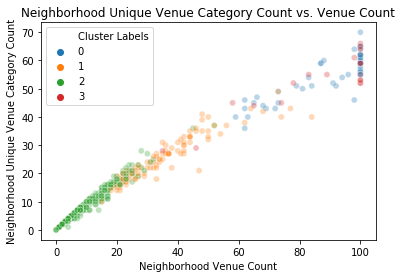

In [45]:
test = tmp[['VenueCnt','UniqueCateCnt','Cluster Labels','City']]
test.insert(4,'Labels',test['Cluster Labels'].astype('category')) 
current_palette = sns.color_palette()
sns.scatterplot(x='VenueCnt', y='UniqueCateCnt', data=test,  hue='Cluster Labels',palette=sns.color_palette(current_palette, kclusters),alpha=0.3) #marker= 'D', 'Set1'


plt.title('Neighborhood Unique Venue Category Count vs. Venue Count')
plt.xlabel('Neighborhood Venue Count')
plt.ylabel('Neighborhood Unique Venue Category Count')


In [ ]:
focusCate=['Grocery Store','Supermarket','Park','Pharmacy','Gym','Gym / Fitness Center','Yoga Studio','Playground','Bus Station','Bus Stop']
Venues_grouped_focus=Venues_grouped[['City','Neighborhood','Latitude','Longitude']+focusCate]
Venues_grouped_focus = pd.merge(Venues_grouped_focus,NBH_grouped)
Venues_grouped_focus.shape

In [ ]:
Venues_grouped_focus['Commute'] = Venues_grouped_focus['Bus Stop'] + Venues_grouped_focus['Bus Station']
Venues_grouped_focus['kidActive'] = Venues_grouped_focus['Park'] + Venues_grouped_focus['Playground']
Venues_grouped_focus['parentActive'] = Venues_grouped_focus['Gym'] + Venues_grouped_focus['Gym / Fitness Center'] + Venues_grouped_focus['Yoga Studio']
Venues_grouped_focus['Shopping'] = Venues_grouped_focus['Grocery Store'] + Venues_grouped_focus['Supermarket']

Venues_grouped_focus.shape

Text(0, 0.5, 'Frequency')

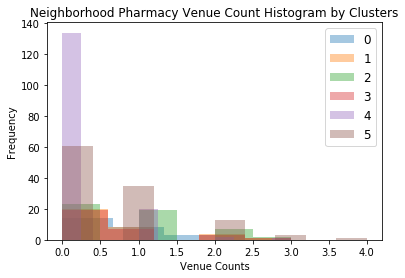

In [175]:
for k in range(0,kclusters):
    df = tmp[tmp['Cluster Labels']==k]
    sns.distplot(df['Pharmacy'],kde=False,label=str(k))

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Neighborhood Pharmacy Venue Count Histogram by Clusters')
plt.xlabel('Venue Counts')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

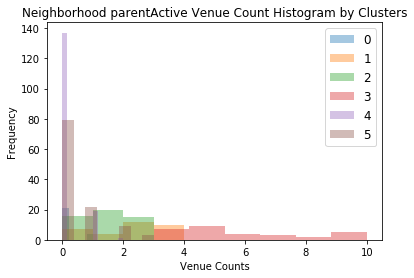

In [181]:
for k in range(0,kclusters):
    df = tmp[tmp['Cluster Labels']==k]
    sns.distplot(df['parentActive'],kde=False,label=str(k))

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Neighborhood parentActive Venue Count Histogram by Clusters')
plt.xlabel('Venue Counts')
plt.ylabel('Frequency')

We'll use the top 100 most retrieved venue categories, and use them as the features for clustering the neighborhoods. We belive that using the top 100 categories is broad enough to catch the essence of the characgteristics of most neighborhoods, but avoid including many (~300)) less common and trivial venues that are probably not in most people's considerations when looking for their future home location. 

In [ ]:
tmp = Venues_grouped.drop(['City','Neighborhood','Latitude','Longitude'],axis=1).sum().sort_values(ascending=False)
tmp.head(100)
selectCate = tmp.index[0:100] # get the selected top 100 venue categories